# Random Forest for biotic/non-biotic test set

Using the same data as the NN gets...


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections
import scipy.io

from sklearn.ensemble import RandomForestClassifier

from time import time

from sklearn import metrics
from sklearn.metrics import roc_curve, auc


import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency


## Loading the data 

In [36]:
datapath = '/home/michael/projects/engaged_hackathon_data/detection/train_test_patches/'
data_small = scipy.io.loadmat(datapath + 'small.mat')
data_big = scipy.io.loadmat(datapath + 'full.mat')

datasetsize = 'full'

data = collections.defaultdict(dict)
data['train_X'] = np.squeeze(data_big['X_train'])
data['train_y'] = data_big['y_train'].ravel()
data['test_X'] = np.squeeze(data_big['X_test'])
data['test_y'] = data_big['y_test'].ravel()

print "The data"
for key, val in data.iteritems():
    print key, val.shape

The data
train_X (50836, 75, 19)
train_y (50836,)
test_y (18286,)
test_X (18286, 75, 19)


## Computing the features 

In [46]:
rf_data = {}

for key in ['train_X', 'test_X']:
    
    all_feats = []
    for spec in data[key]:
        filter_pooling_list = []
        for filt in engaged_features.gauss_filters_generator(spec, deviation=6):
            max_pooled_filt = filt.max(1)
            filter_pooling_list.append(max_pooled_filt)
        
        filter_pooling = np.hstack(filter_pooling_list)
        all_feats.append(filter_pooling)
        
    rf_data[key] = np.vstack(all_feats)
    
    print key, rf_data[key].shape

train_X (50836, 450)
test_X (18286, 450)


## Training the forest...

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(rf_data['train_X'], data['train_y'])

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

## Testing and evaluating 

In [39]:
# now test on the test data...
pred_y = rf.predict_proba(rf_data['test_X'])[:, 1]

In [40]:
from sklearn.metrics import accuracy_score
print accuracy_score(data['test_y'], pred_y>0.5)

0.750957016297


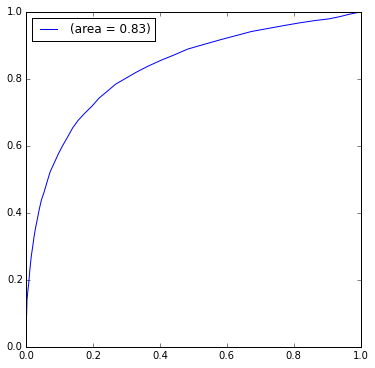

In [49]:
from sklearn.metrics import roc_curve, auc

# plotting this line
plt.figure(figsize=(6, 6))
fpr, tpr, _ = roc_curve(data['test_y'], pred_y.ravel())

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr , label='(area = %0.2f)' % (roc_auc))
plt.legend(loc='best')